In [ ]:
!pip install gpustat

In [ ]:
!gpustat

40901ffca701  Mon Apr 29 19:13:44 2024  535.104.05
[0] Tesla T4 | 76°C,   0 % | 14159 / 15360 MB |


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

**Import necessary libraries**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import namedtuple
from sklearn import preprocessing
from bert import bert_tokenization
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.15.0
Hub version:  0.16.1


**Importing Dataset**

In [ ]:
# Load train and val datasets
df = pd.read_csv('/content/drive/MyDrive/NLP Datasets/marathi_preprocessed.csv')


In [ ]:
# Columns
df.columns

Index(['tweet', 'label'], dtype='object')

In [ ]:
# Print hate rows
rows_with_label_0 = df[df['label'] == 0]
print(rows_with_label_0.head())


                                                  tweet  label
1444  राम कदम वागण्यात बोलण्यात चुकला बीजेपी मग अजित...      0
1445  हीच तुमची शिवसेने चि शिकवण आपली आई दैवत दुसऱ्य...      0
1446  वाचा गाढवांनो सांगा तुमच्या मॅडम पप्पूने साली ...      0
1447                     भक्त आंधळे असतात मूर्खा ना कळत      0
1448  छत्रपती शिवाजी महाराज जागतिक दर्जाच्या सम्राटा...      0


In [ ]:
df= df.dropna()

In [ ]:
df['label']

0       1
1       1
2       1
3       1
4       1
       ..
3514    0
3515    0
3516    0
3517    1
3518    1
Name: label, Length: 3519, dtype: int64

**Convert labels to one-hot encoding and in required shape**

In [ ]:
import numpy as np

# Convert labels to one-hot encoding
num_classes = 2
labels_one_hot = np.zeros((df['label'].size, num_classes))
labels_one_hot[np.arange(df['label'].size), df['label']] = 1
print("Updated shape of label_one_hot:", labels_one_hot.shape)

Updated shape of train_y_one_hot: (3519, 2)


**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and temporary sets (80% training, 20% temp)
train_x, temp_x, train_y, temp_y = train_test_split(df['tweet'], labels_one_hot, test_size=0.2, random_state=42)

# Further split the temporary set into validation and testing sets (50% validation, 50% testing)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=42)

**Functions to create input features**

In [ ]:
# Function to create input_ids
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

# Function to create attention masks
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

# Function to create segment ids
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

# Function to create input_ids, attention_masks, segment_ids for sample
def create_single_input(sentence,MAX_LEN, MAX_SEQ_LEN):

  stokens = tokenizer.tokenize(sentence)

  stokens = stokens[:MAX_LEN]

  stokens = ["[CLS]"] + stokens + ["[SEP]"]

  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids,masks,segments

def create_input_array(sentences, MAX_SEQ_LEN):

  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):

    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2, MAX_SEQ_LEN)

    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32),
            np.asarray(input_masks, dtype=np.int32),
            np.asarray(input_segments, dtype=np.int32)]

**Importing Muril Model Layer**

In [ ]:
# MuRIL model layer
muril_layer = hub.KerasLayer("https://tfhub.dev/google/MuRIL/1", trainable=True)

# Create tokenizer
vocab_file = muril_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = muril_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

**Defining train_x, test_x, val_x**

In [ ]:
# Create input_ids, attention_masks, segment_ids for training and validation sets with max_seq_len as 128
max_seq_len = 128
train_x = create_input_array(train_x, max_seq_len)
val_x = create_input_array(val_x, max_seq_len)
test_x=create_input_array(test_x, max_seq_len)

100%|██████████| 352/352 [00:00<00:00, 1442.46it/s]


**Define Model Function**

In [ ]:
# # Define model function - compile and fit
import tensorflow as tf

def model_fit(train_x, train_y, val_x, val_y, max_seq_length, num_epochs, muril_layer):

    # Define input layers
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

    # Muril layer
    outputs = muril_layer(dict(input_word_ids=input_word_ids, input_mask=input_mask, input_type_ids=segment_ids))

    # Dropout layer
    x = tf.keras.layers.Dropout(0.2)(outputs["pooled_output"])

    # Output layer for binary classification
    final_output = tf.keras.layers.Dense(2, activation="softmax", name="dense_output")(x)

    # Define the model
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=final_output)

     # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=16, validation_data=(val_x, val_y), shuffle=True)

    return model


**Set Epochs and Fit Model**

In [ ]:
# Set number of epochs
num_epochs = 3

# Get the model object
model = model_fit(train_x, train_y, val_x, val_y, max_seq_len, num_epochs, muril_layer)

Epoch 1/3
176/176 [==============================] - 132s 477ms/step - loss: 0.6245 - accuracy: 0.6654 - val_loss: 0.5058 - val_accuracy: 0.7074
Epoch 2/3
176/176 [==============================] - 84s 477ms/step - loss: 0.4594 - accuracy: 0.8021 - val_loss: 0.3039 - val_accuracy: 0.9034
Epoch 3/3
176/176 [==============================] - 84s 477ms/step - loss: 0.3059 - accuracy: 0.8970 - val_loss: 0.2299 - val_accuracy: 0.9261


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 keras_layer_3 (KerasLayer)  {'encoder_outputs': [(None   2375562   ['input_mask[0][0]',    

**Testing Phase**

In [ ]:
# Make predictions
preds = model.predict(test_x)

11/11 [==============================] - 3s 277ms/step


In [ ]:
from sklearn.metrics import f1_score

# After training the model using model_fit function

# 1. Make predictions on the validation set
pred_probs = model.predict(test_x)

# 2. Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_probs, axis=1)

# 3. Calculate F1 score
f1 = f1_score(np.argmax(test_y, axis=1), pred_labels)

print("F1 Score:", f1)


11/11 [==============================] - 3s 280ms/step
F1 Score: 0.910569105691057


In [ ]:
pred_labels

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,

In [ ]:
import numpy as np

# Assuming pred_labels contains the predicted labels
num_ones = np.count_nonzero(pred_labels == 1)

print("Number of predicted 1s:", num_ones)


Number of predicted 1s: 243


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       103
           1       0.92      0.90      0.91       249

    accuracy                           0.88       352
   macro avg       0.85      0.86      0.85       352
weighted avg       0.88      0.88      0.88       352



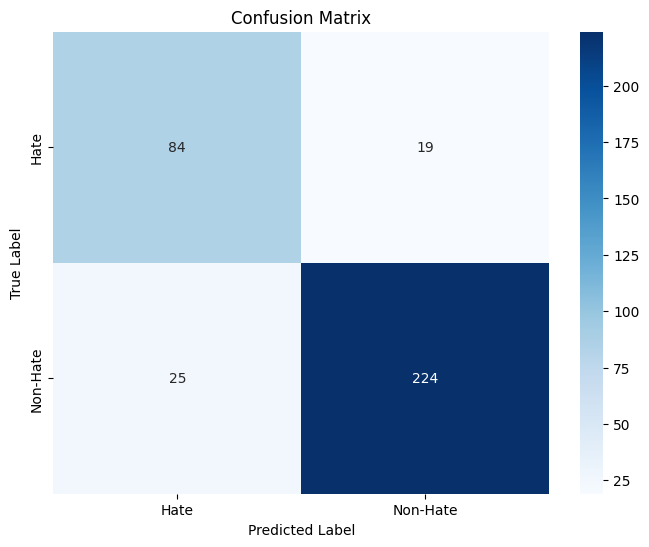

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# # Convert true labels to class labels
true_labels = np.argmax(test_y, axis=1)

# Generate classification report
report = classification_report(true_labels, pred_labels)

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print("Classification Report:")
print(report)


# Plot the confusion matrix
label_names = ['Hate','Non-Hate']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()